# Com S 574 - HW 1
## Miles Lucas

In [99]:
# Setup
import plotly.offline as plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf
import pandas as pd
import numpy as np
plotly.init_notebook_mode(connected=True)

### Problem 1
---

Using test point 
$$ X_1=X_2=X_3=0  $$

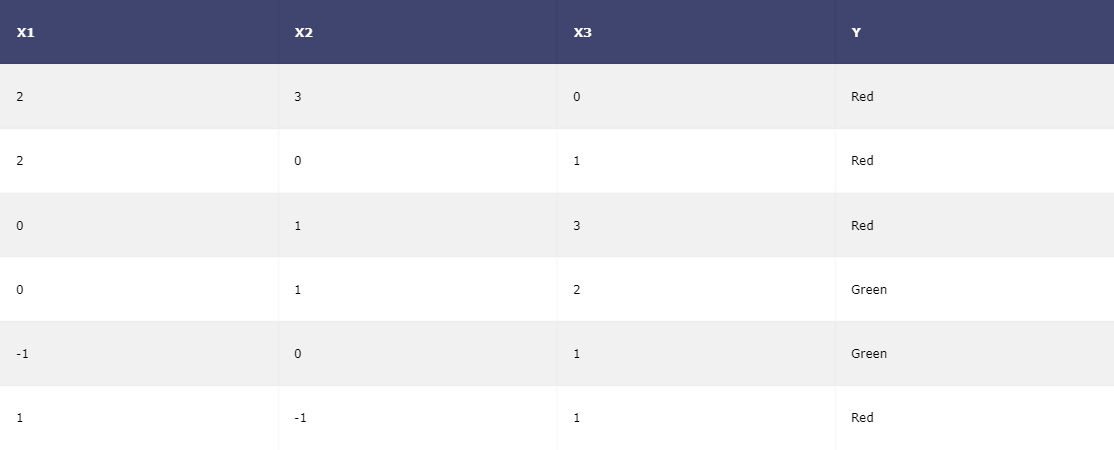

In [91]:
# Set up Data
observations = pd.DataFrame({
    'X1': [2, 2, 0, 0, -1, 1], 
    'X2': [3, 0, 1, 1, 0, -1], 
    'X3': [0, 1, 3, 2, 1, 1], 
    'Y': ["Red", "Red", "Red", "Green", "Green", "Red"]
})
plotly.iplot(ff.create_table(observations))

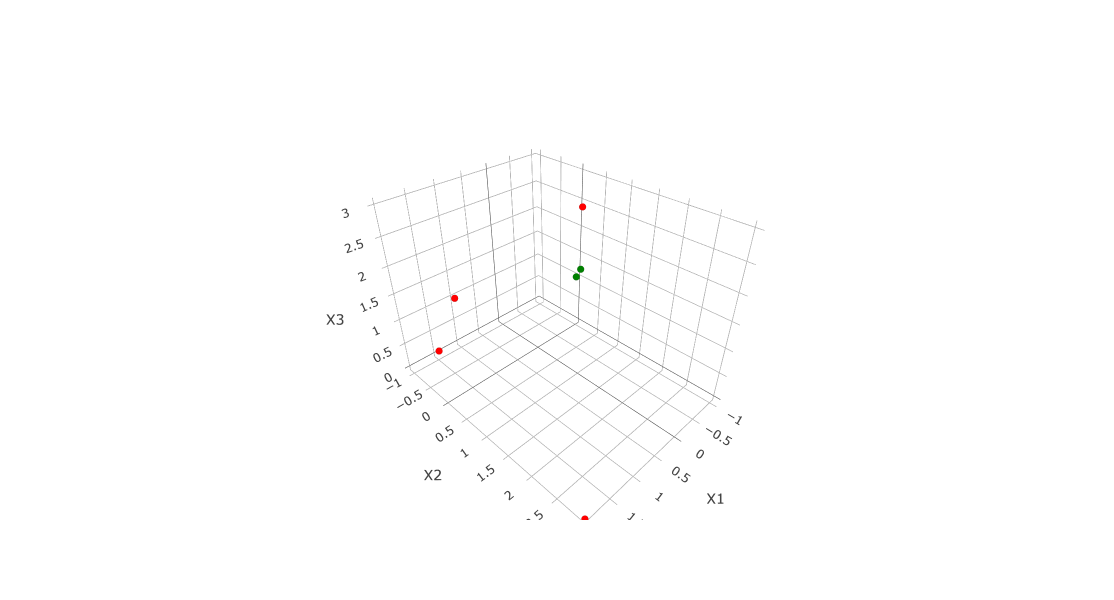

In [103]:
trace = go.Scatter3d(
    x=observations['X1'], 
    y=observations['X2'], 
    z=observations['X3'],
    mode='markers',
    marker = dict(
        size=4,
        color=observations['Y'].apply(lambda s: s.lower())
    )
)
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X1'),
        yaxis=dict(title='X2'),
        zaxis=dict(title='X3'),
    ),
    height=600
)
fig = go.Figure(data=[trace], layout=layout)
plotly.iplot(fig)

#### a)
The Euclidean distance in cartesian coordinates between 2 points is given using the formula

$$ D(\vec{r}_1, \vec{r}_2) = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2} $$

This is conveniently implemented in the numpy.linalg.norm function


In [37]:
Xtest = np.zeros(3)

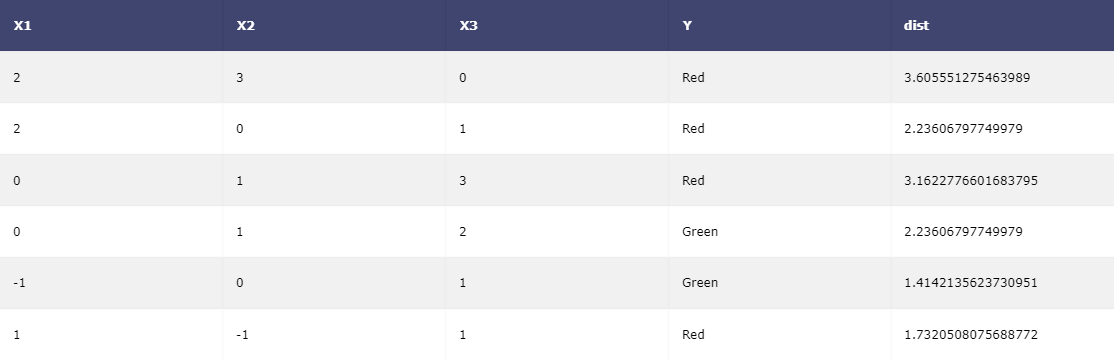

In [174]:
observations['dist'] = np.linalg.norm(observations[['X1', 'X2', 'X3']]-Xtest, axis=1)
plotly.iplot(ff.create_table(observations))

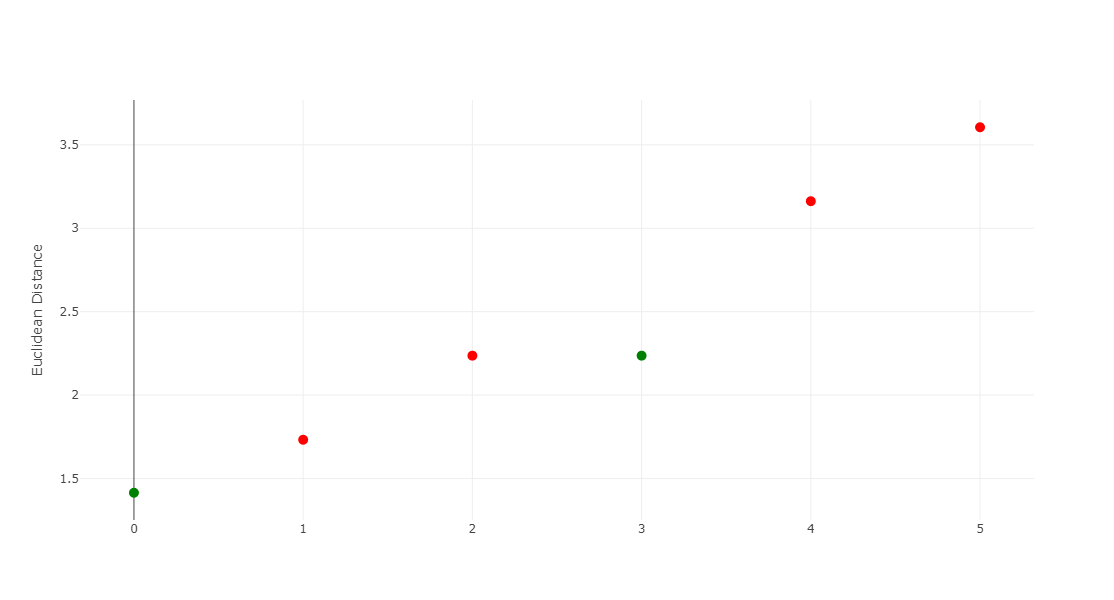

In [176]:
sorted_obs = observations.sort_values('dist')
trace = go.Scatter(
    y=sorted_obs['dist'],
    mode='markers',
    marker = dict(
        size=10,
        color=sorted_obs['Y'].apply(lambda s: s.lower())
    ),
)
layout = go.Layout(
    yaxis = dict(
        title='Euclidean Distance'
    ),
    height=600
)
fig = go.Figure([trace], layout)
plotly.iplot(fig)

#### b) 
To make estimates, I will look at what observation the nearest point had- `Green`. So I would predict that my test point would observe `Green`

#### c)
Similarly, the closest 3 points are `[Green, Red, Red/Green]`. There is a tie in the 3rd closest point, (observations 2 and 4). For a tie-breaker, I will choose whichever one shows up first in the sorting according to python, which is `Red`. Therefore, there is $\frac13$ chance of the test point being `Green`, and $\frac23$ chance of being `Red`, so I would predict `Red`

#### d)
If the Bayes decision boundary is highly non-linear, we should expect the best-fit $K$ to be small. If we use too large of $K$ our boundary estimator won't be flexible enough to handle the non-linearities of the true conditional distribution. However, if we choose too small of $K$ our boundary might over-fit and lead to a large testing error.

### Problem 2: KNN Implementation (Python)
---
The K nearest neighbors creates a conditional probability distribution given the $K$ nearest points to a test point. In our instance, we have calculated the Euclidian distance from the test point, so we can find the nearest neighbors by getting the first $K$ points from the sorted dataframe. The probabilities end up looking like

$$ P(Y=j | X=x_0) = \frac1K \sum_{i\in{N_0}}{I(y_i=j)} $$

where $N_0$ is the subset of nearest neighbors in the observation set and $j$ are the possible classes

$$ j \in \{\text{"Red"}, \text{"Green"} \} $$

In [77]:
trainX = observations[['X1', 'X2', 'X3']].values
trainY = observations['Y'].values

In [116]:
def knn(k, trainx, trainy, testx):
    """
    KNN algorithm

    Parameters
    ----------
    k : int
        the number of neighbors to consider
    trainx : array_like
        the training sets of independent variables
    trainy : array_like
        the training set of observations
    testx : array_like
        the testing set of independent variables

    Returns
    -------
    category, probability : tuple
        The predicted category and its corresponding probability

    Note
    ----
    There is no real tie-breaking here.
    """
    dist = np.sqrt(np.linalg.norm(trainx - testx, axis=1))
    sorted_obs = trainy[np.argsort(dist)]
    neighbors = sorted_obs[:k]
    probs = {}
    for category in np.unique(neighbors):
        probs[category] = np.sum(neighbors == category) / len(neighbors)
    predicted = max(probs, key=probs.get)
    predicted_prob = probs[predicted]
    return predicted, predicted_prob

#### b)

Check if KNN with $K$=1 and 3 matches my predictions from problem 1.

In [114]:
knn(1, trainX, trainY, Xtest)

('Green', 1.0)

In [115]:
knn(3, trainX, trainY, Xtest)

('Red', 0.6666666666666666)

### Problem 3
---
Model:

$$ Y_i = \beta_1 x_i + e_i $$

Given:

$$ \text{E}(e_i) = 0 $$
$$ \text{Var}(e_i) = \sigma_e^2 $$
$$ \text{Cov}(e_i, e_j) = 0, \quad \forall i \neq j $$

#### a) least squares estimation

$$ \hat{Y}_i = \hat\beta_1 x_i $$

Least squares loss function:

$$ \text{loss}(\hat\beta_1) = \sum_i {\left(\hat{Y_i} - Y_i\right)^2} $$

Find 
$$ \underset{\hat\beta_1}{\text{argmin}} \left[\sum_i {\left(\hat\beta_1 x_i - Y_i\right)^2} \right] $$
by using
$$ \nabla \text{loss} = \vec{0} $$

\begin{align}
\nabla \text{loss} & = \frac{d \text{loss}}{d \hat\beta_1} \\
                   & = \sum_i \left[ \frac{d}{d\hat\beta_1} \left( \hat\beta_1 x_i - y_i\right)^2 \right] \\
                   & = 2 \sum_i{\hat\beta_1 x_i^2 - x_i Y_i}
\end{align}

setting this to 0 leads to 
$$ \hat\beta_1 = \frac{\sum_i {x_i Y_i}}{\sum_j{x_j^2}} $$

#### b) bias

Finding the bias amounts to finding the expected value of the estimator $\hat\beta_1$

\begin{align}
\mathbb{E}(\hat\beta_1) & = \mathbb{E}\left[ \frac{\sum_i {x_i (\beta_1 x_i + e_i)}}{\sum_j{x_j^2}} \right] \\
                        & = \mathbb{E}\left[ \frac{\sum_i {\beta_1 x_i^2 + \beta_1 x_i e_i}}{\sum_j{x_j^2}} \right] \\
                        & = \frac{\sum_i {\beta_1 x_i^2 + \beta_1 x_i \mathbb{E}( e_i)}}{\sum_j{x_j^2}}, \quad \mathbb{E}(e_i)=0 \\
                        & = \frac{\sum_i {\beta_1 x_i^2}}{\sum_j{x_j^2}} \\
                        & = \beta_1 \frac{\sum_i {x_i^2}}{\sum_j{x_j^2}} \\
                        & = \beta_1
\end{align}

so our estimator is unbiased. To me this makes sense, because of you consider the derivation of OLS using matrices, it has the same properties, regardless of the rank of the $\mathbf{\beta}$ matrix.

#### c) variance

\begin{align}
\mathbb{V}(\hat\beta_1) & =  
\end{align}

In [171]:
x = np.linspace(1, 100, 100)
y = 4 * x + 20*np.random.randn(100)

beta = (x @ y)/(x @ x)
y_pred = beta * x

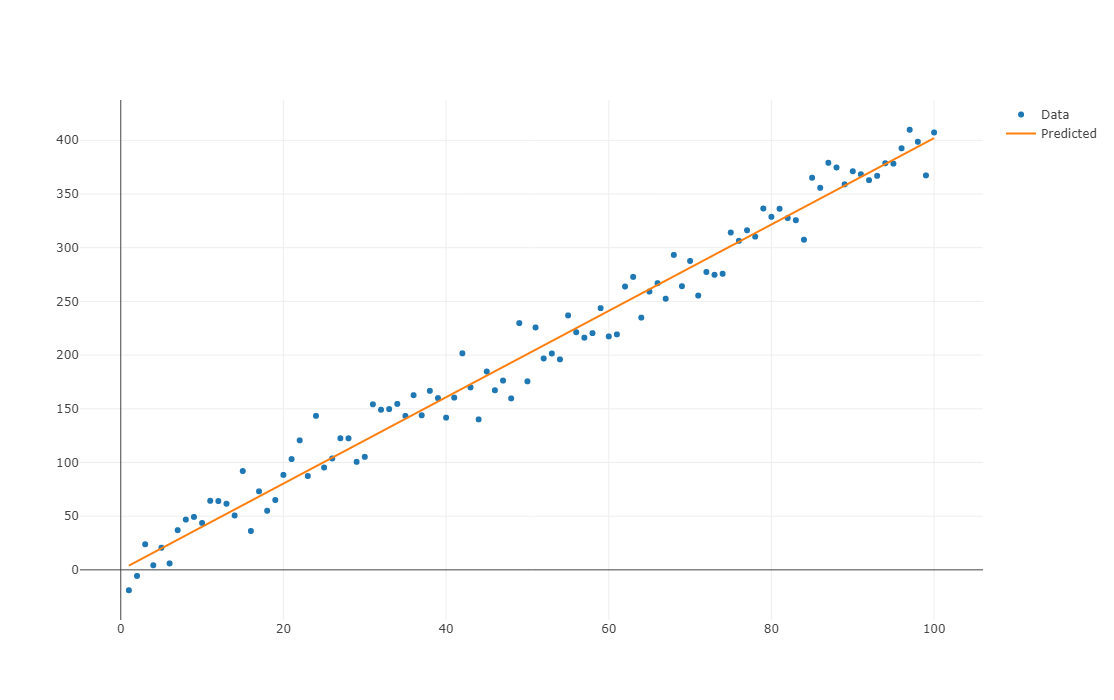

In [172]:
trace0 = go.Scatter(
    x=x,
    y=y,
    mode='markers',
    name='Data'
)
trace1 = go.Scatter(
    x=x,
    y=y_pred,
    name='Predicted'
)
layout = go.Layout(
    showlegend=True,
    height=700
)
fig = go.Figure(data=[trace0, trace1], layout=layout)
plotly.iplot(fig)